In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

import numpy as np
import matplotlib.pyplot as plt

import time

In [2]:
def init_weights(in_dim, out_dim):
    std = np.sqrt(1 / in_dim)
    return np.random.normal(0, std, (in_dim, out_dim))

### Load and format data

In [3]:
ITR = 50000
B = 10
lr = 1e-4
ks = [5, 50, 200]

train_data_raw = datasets.MNIST(root='./data', train=True, download=True)
test_data_raw = datasets.MNIST(root='./data', train=False, download=True)

train_images = np.array([np.array(train_data_raw.data[i]).flatten() for i in range(len(train_data_raw))])
mean = train_images.mean()
std = train_images.std()

train_data = []
for i in range(len(train_data_raw)):
    x = (np.array(train_data_raw.data[i]).flatten() - mean) / std
    x = np.append(x, 1.0)
    y = int(train_data_raw.targets[i] > 4)
    train_data.append((x, y))

test_data = []
for i in range(len(test_data_raw)):
    x = (np.array(test_data_raw.data[i]).flatten() - mean) / std
    x = np.append(x, 1.0)
    y = int(test_data_raw.targets[i] > 4)
    test_data.append((x, y))

### Use linear classifier as baseline

In [4]:
norm_factor = 1e-3

def SGD_Linear(ITR, B, lr, data, eval_data = True):
    start_time = time.time()
    W = init_weights(785, 1)
    N = len(data)

    x_vals = []
    train_acc = []
    test_acc = []
    for i in range(ITR):
        random_items = np.random.choice(N, size=B, replace=True)
        X = np.vstack([data[j][0] for j in random_items])
        y = np.vstack([data[j][1] for j in random_items])

        loss_grad = X.T @ (X @ W - y)
        grad = (1.0 / B) * loss_grad + norm_factor * W
        W = W - lr * grad

        if eval_data and i % (ITR // 100) == 0: # only record 100 points or else graph is too dense
            predictions = (X @ W > 0.5).astype(int)
            acc = np.mean(predictions == y) * 100
            train_acc.append(acc)
            
            X_test = np.vstack([test_data[j][0] for j in range(len(test_data))])
            y_test = np.vstack([test_data[j][1] for j in range(len(test_data))])

            x_vals.append(i)

            predictions = (X_test @ W > 0.5).astype(int)
            acc = np.mean(np.mean(predictions == y_test)) * 100
            test_acc.append(acc)
    
    end_time = time.time() - start_time
    
    fig, ax = plt.subplots(figsize=(12, 6))
    ax.plot(x_vals, train_acc, label="Train")
    ax.plot(x_vals, test_acc, label="Test")
    ax.set_title(f"Accuracy for Linear Classifier (Accuracy: {test_acc[-1]:.2f}%, time: {end_time:.2f}s)")
    ax.set_xlabel("Iteration")
    ax.set_ylabel("Accuracy (%)")
    ax.legend()
    plt.show()

    return W, test_acc[-1]

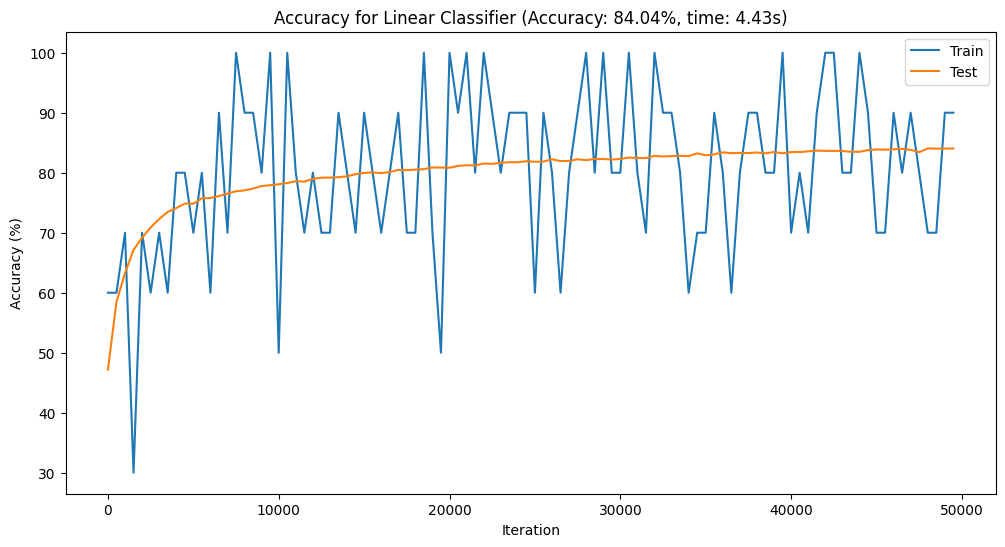

Final accuracy: 84.04%


In [5]:
W, acc = SGD_Linear(ITR, B, lr, train_data)
print(f"Final accuracy: {acc:.2f}%")

#### NN with quadratic loss

In [6]:
def SGD_NN_Quadratic(ITR, B, lr, data, k=10, eval_data=True):
    start_time = time.time()
    W = init_weights(785, k)
    v = init_weights(k, 1)
    N = len(data)

    x_vals = []
    train_acc = []
    test_acc = []
    for i in range(ITR):
        random_items = np.random.choice(N, size=B, replace=True)
        X = np.vstack([data[j][0] for j in random_items])
        y = np.vstack([data[j][1] for j in random_items])

        relu = np.maximum(0, X @ W)
        output = relu @ v
        error = output - y

        dL_dy = 1.0 / B * error

        # gradient of v is dL_dy * dy_dv
        dL_dv = relu.T @ dL_dy

        # gradient of W is dL_dy * dy_drelu * drelu_dW
        dL_drelu = dL_dy @ v.T
        dL_dW = X.T @ (dL_drelu * (relu > 0))

        v = v - lr * dL_dv
        W = W - lr * dL_dW

        if eval_data and i % (ITR // 100) == 0: # only record 100 points or else graph is too dense
            predictions = (output > 0.5).astype(int)
            acc = np.mean(predictions == y) * 100  
            train_acc.append(acc)
            
            X_test = np.vstack([test_data[j][0] for j in range(len(test_data))])
            y_test = np.vstack([test_data[j][1] for j in range(len(test_data))])

            x_vals.append(i)

            relu_test = np.maximum(0, X_test @ W)
            predictions = (relu_test @ v > 0.5).astype(int)

            acc = np.mean(predictions == y_test) * 100
            test_acc.append(acc)

    end_time = time.time() - start_time
    
    fig, ax = plt.subplots(figsize=(12, 6))
    ax.plot(x_vals, train_acc, label="Train")
    ax.plot(x_vals, test_acc, label="Test")
    ax.set_title(f"Accuracy for Quadratic NN (k={k}, Accuracy: {test_acc[-1]:.2f}%, time: {end_time:.2f}s)")
    ax.set_xlabel("Iteration")
    ax.set_ylabel("Accuracy (%)")
    ax.legend()
    plt.show()

    return W, v, test_acc[-1]

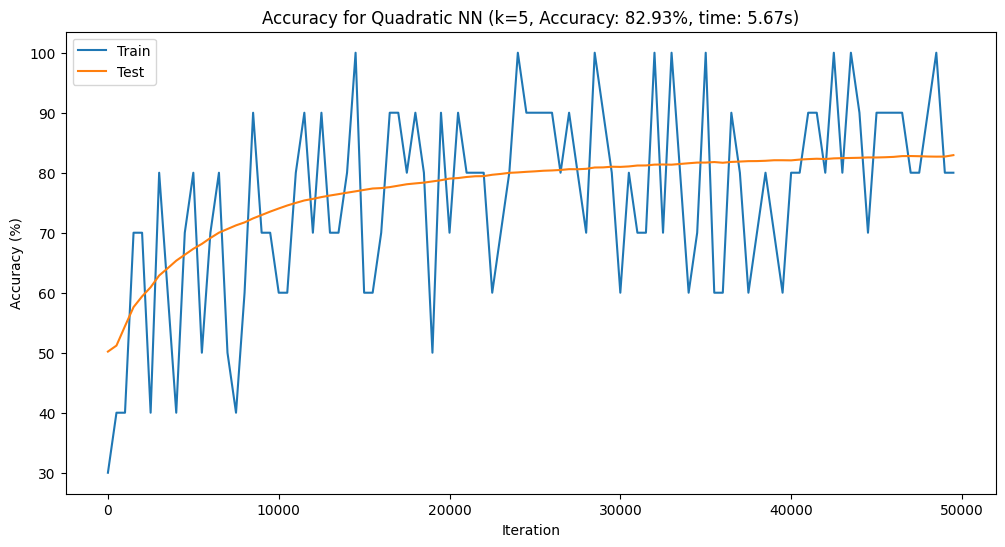

Final accuracy: 82.93%


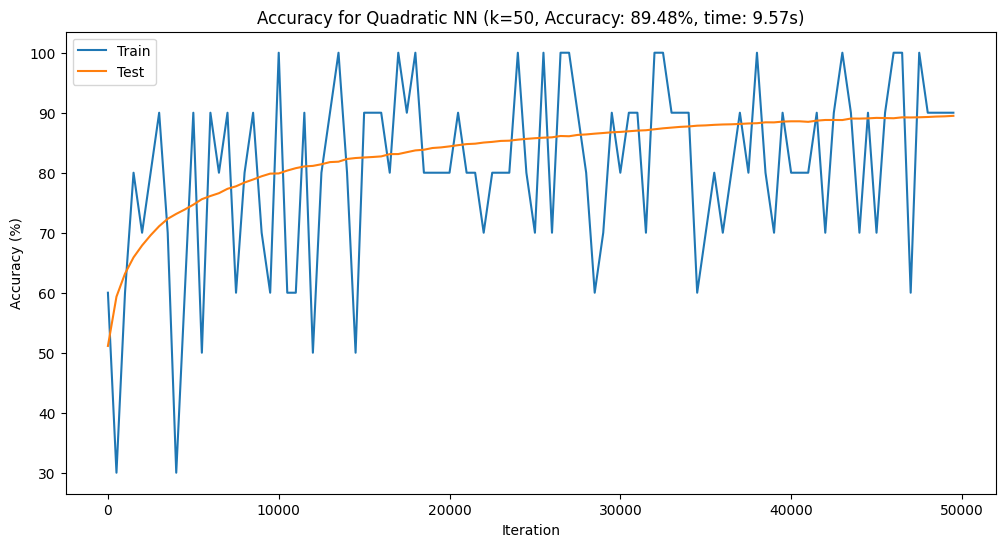

Final accuracy: 89.48%


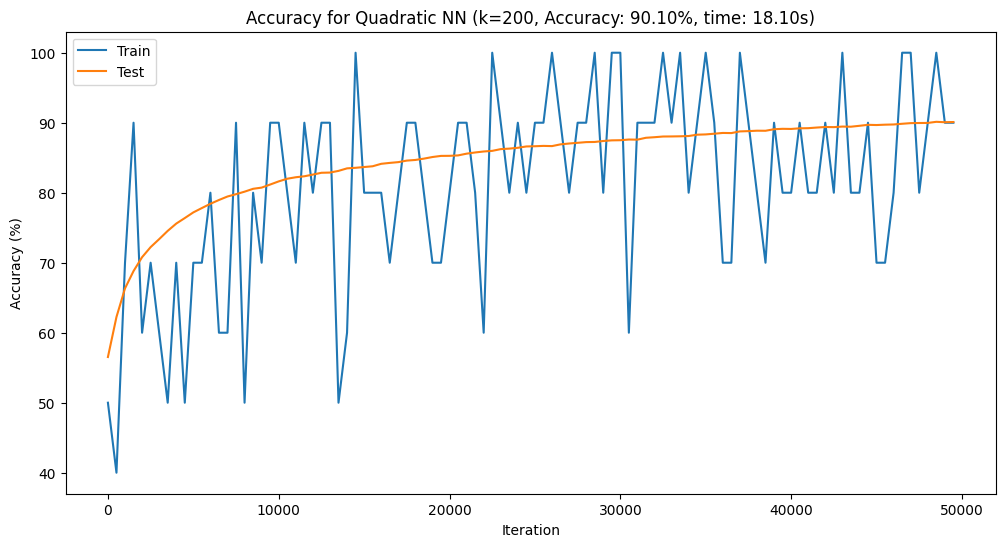

Final accuracy: 90.10%


In [7]:
for k in ks:
    W, v, acc = SGD_NN_Quadratic(ITR, B, lr, train_data, k=k, eval_data=True)
    print(f"Final accuracy: {acc:.2f}%")

#### NN with logistic loss

In [8]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def SGD_NN_Logistic(ITR, B, lr, data, k=10, eval_data=True):
    start_time = time.time()
    W = init_weights(785, k)
    v = init_weights(k, 1)
    N = len(data)

    x_vals = []
    train_acc = []
    test_acc = []
    for i in range(ITR):
        random_items = np.random.choice(N, size=B, replace=True)
        X = np.vstack([data[j][0] for j in random_items])
        y = np.vstack([data[j][1] for j in random_items])

        relu = np.maximum(0, X @ W)
        output = relu @ v
        p = sigmoid(output)

        dL_dy = 1.0 / B * (p - y)

        # gradient of v is dL_dy * dy_dv
        dL_dv = relu.T @ dL_dy

        # gradient of W is dL_dy * dy_drelu * drelu_dW
        dL_drelu = dL_dy @ v.T
        dL_dW = X.T @ (dL_drelu * (relu > 0))

        v = v - lr * dL_dv
        W = W - lr * dL_dW

        if eval_data and i % (ITR // 100) == 0: # only record 100 points or else graph is too dense
            acc = np.mean((p > 0.5).astype(int) == y) * 100
            train_acc.append(acc)
            
            X_test = np.vstack([test_data[j][0] for j in range(len(test_data))])
            y_test = np.vstack([test_data[j][1] for j in range(len(test_data))])

            x_vals.append(i)

            relu_test = np.maximum(0, X_test @ W)
            output_test = relu_test @ v
            p_test = sigmoid(output_test)

            acc = np.mean((p_test > 0.5).astype(int) == y_test) * 100
            test_acc.append(acc)

    end_time = time.time() - start_time
    
    fig, ax = plt.subplots(figsize=(12, 6))
    ax.plot(x_vals, train_acc, label="Train")
    ax.plot(x_vals, test_acc, label="Test")
    ax.set_title(f"Accuracy for Logistic NN (k={k}, Accuracy: {test_acc[-1]:.2f}%, time: {end_time:.2f}s)")
    ax.set_xlabel("Iteration")
    ax.set_ylabel("Accuracy (%)")
    ax.legend()
    plt.show()

    return W, v, test_acc[-1]

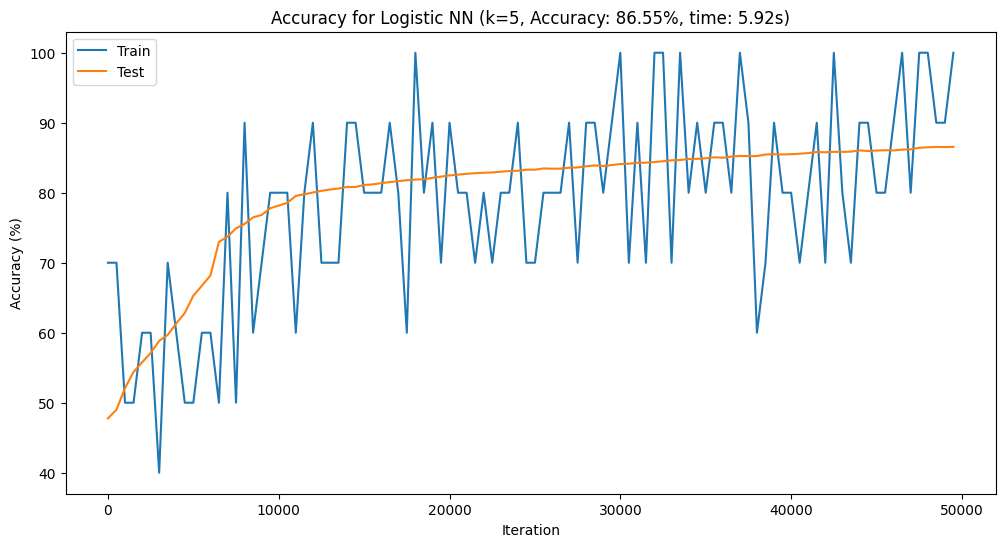

Final accuracy: 86.55%


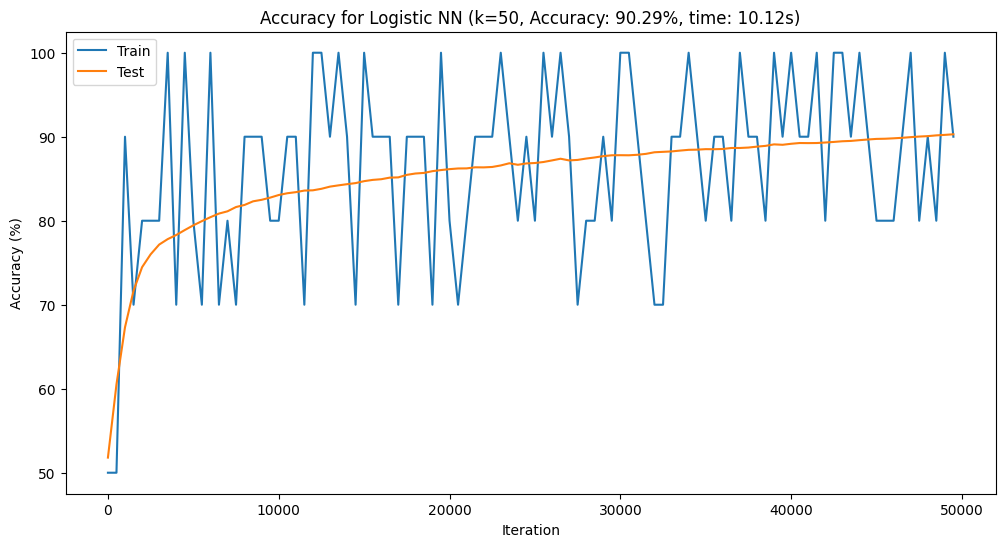

Final accuracy: 90.29%


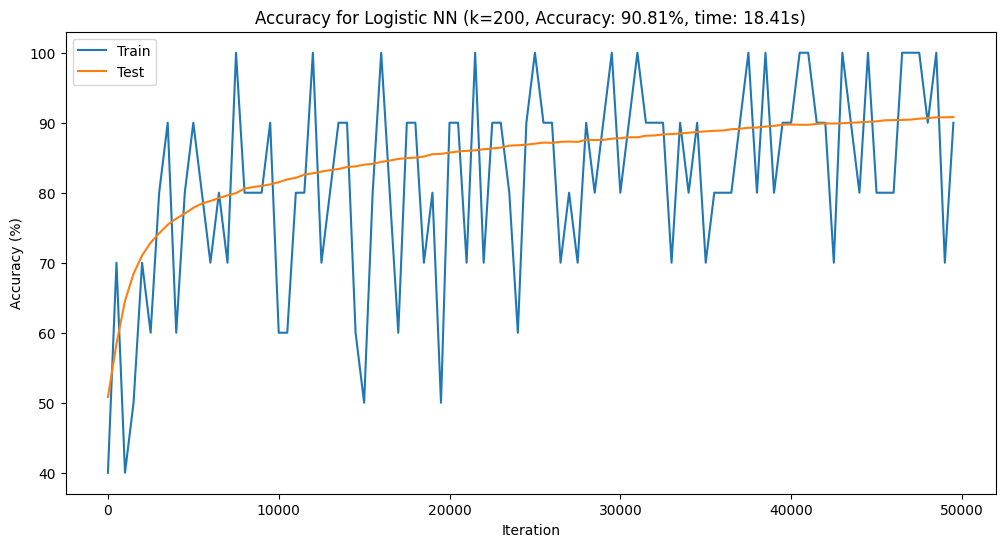

Final accuracy: 90.81%


In [9]:
for k in ks:
    W, v, acc = SGD_NN_Logistic(ITR, B, lr, train_data, k=k, eval_data=True)
    print(f"Final accuracy: {acc:.2f}%")